W implementacji wykorzystano przykład: https://keras.io/examples/vision/siamese_network/

# 1.Konfiguracja



1.1 Import niezbędnych bibliotek

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import vgg19

In [ ]:
import time
start_time = time.time()

1.2. Import zbioru danych znajdującego się na portalu Kaggle.com

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'twmprojekt'
os.environ['KAGGLE_KEY'] = '7cbe815cea0bf6c29fbff1cac69cba0c'

Funkcja pozwalająca na wybór zbioru danych

In [ ]:
import os
def select_dataset(mode):
  os.mkdir('/content/dataset')
  os.chdir('/content/dataset')

  if mode == "PCB_WHOLE":
    dataset = 'SIAM_typeA_left'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")
    

  elif mode == "PCB_SECTIONS":
    dataset = 'SIAM_typeA_bySections/SIAM_typeA_bySections/section1'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")

  elif mode == "PCB_TYPEC_WHOLE":
    dataset = 'SIAM_typeC_right/SIAM_typeC_right'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")

  elif mode == "PCB_TYPEC_SECTION_1":
    dataset = 'SIAM_typeC_sections/SIAM_typeC_sections/section1'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")

  elif mode == "PCB_TYPEC_SECTION_2":
    dataset = 'SIAM_typeC_sections/SIAM_typeC_sections/section2'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")

  elif mode == "PCB_TYPEC_SECTION_3":
    dataset = 'SIAM_typeC_sections/SIAM_typeC_sections/section3'
    os.system("kaggle datasets download -d twmprojekt/printedcircutboard --unzip")
     
  elif mode == "CRACKS":
    dataset = 'dataset_siam/dataset_siam/dataset_siam'
    os.system("kaggle datasets download -d twmprojekt/cracks-mobidev --unzip")

    

  else:
    raise NotImplementedError(f"The specified mode: {mode} is not recognized")

  
  os.mkdir('keras')
  return dataset
  


In [ ]:
dataset = select_dataset("PCB_TYPEC_SECTION_1")
target_shape = (200, 200)

Przeniesienie zdjęć do treningu i walidacji algorytmu do przestrzeni roboczej (katalog keras)

In [ ]:
!mv $dataset"/anchor/" "keras/"
!mv $dataset"/positive/" "keras/"
!mv $dataset"/negative/" "keras/"

Funkcje:


*   `preprocess_image(filename)`:

 - konwersja zdjęcia z formatu JPEG na tensor typu `double float 32`
 - dostosowuję wymiar zdjęcia do wymiaru kompatybilnego z siecią

*   `preprocess_triplets(anchor, positive, negative)`

  - wyokonuje operacje przetwarzania wstępnego dla tripletu zdjęć



In [ ]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

Określenie ścieżek do folderów zawierających zdjęcia:


*   `anchor` - zdjęcia modelowe
*   `positives` - zdjęcia do detekcji (poprawne)
*   `negatives` - zdjęcia do detekcji (nie poprawne)



In [ ]:
anchor_images_path = Path("./keras/anchor")
positive_images_path = Path("./keras/positive")
negative_images_path = Path("./keras/negative")
print(os.listdir(positive_images_path))

['sample38p_jpg.rf.081ea0b67e40fff201c981e16e8312d0.jpg', 'sample41p_jpg.rf.e11aee6a7c2523f2d00ea32e9a7214a3.jpg', 'sample32p_jpg.rf.188c842e99e59653322541f2be1505a1.jpg', 'sample39p_jpg.rf.7f92e460d60e0ae9ba0ddc76c8d3ec9d.jpg', 'sample38p_jpg.rf.c58877d58570d799b07a368ed231ecac.jpg', 'sample40p_jpg.rf.232204a4218c76cd06314bb6d036d6ab.jpg', 'sample27p_jpg.rf.f82aba4e6ed86ba14d57492edbb5053a.jpg', 'sample40p_jpg.rf.b055483d9bac506c3942d66cbfa95e63.jpg', 'sample42p_jpg.rf.eecdd76d2a093caede8859c9aa5c07aa.jpg', 'sample43p_jpg.rf.4cfcba32357af201f15756b9f0d522f5.jpg', 'sample44p_jpg.rf.e35343f34d91bbc14ecf9201b67ca119.jpg', 'sample31p_jpg.rf.059dfcd723fd3bbc0135a9dc0e282244.jpg', 'sample39p_jpg.rf.c891c7ff49a7307c61d59878e8e01f53.jpg', 'sample32p_jpg.rf.255e7cc249e392a307f56b74a9288399.jpg', 'sample27p_jpg.rf.6a49b3a9cecdae3c43a8e39fe8452d10.jpg', 'sample39p_jpg.rf.7f1c0f9768fced0b2a0ebac2371e5039.jpg', 'sample27p_jpg.rf.4db2116a058ce9d7b65588e69e0f25dc.jpg', 'sample45p_jpg.rf.a3a3e2eeee3a

1.3. Wczytanie zdjęć

In [ ]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

negative_images = sorted(
    [str(negative_images_path / f) for f in os.listdir(negative_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((
    anchor_dataset, positive_dataset, negative_dataset)
)
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Podział na zdjęcia treningowe i testowe
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

1.3. Wizualizacja

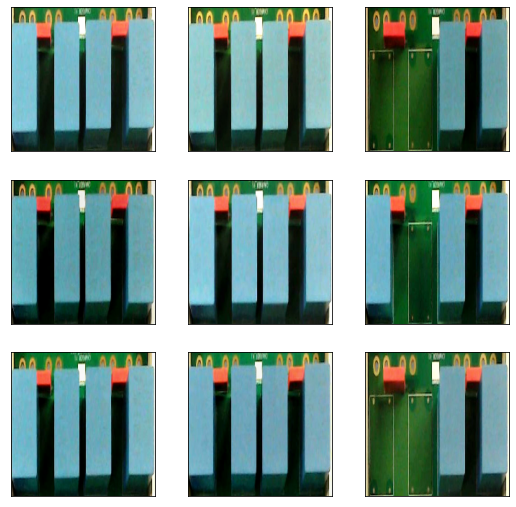

In [ ]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])



# 2. Architektura Sieci

2.1. Model bazowy

In [ ]:
base_cnn = resnet.ResNet152(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

234698864/234698864 [==============================] - 1s 0us/step


2.2. Warstwa odległości

In [ ]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

2.3 Syjamksa architektura z trójkową funkcją straty

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

# 3. Trening sieci

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset)



Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 0.0506

4/4 [==============================] - 44s 4s/step - loss: 0.0506 - val_loss: 0.0000e+00
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 0.0052

4/4 [==============================] - 5s 1s/step - loss: 0.0052 - val_loss: 0.0000e+00
Epoch 7/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/30
4/4 [==============================] - ETA: 0s - loss: 0.1130

4/4 [==============================] - 5s 1s/step - loss: 0.1130 - val_loss: 0.0000e+00
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/30
4/4 [==============================] - ETA: 0s - loss: 0.0225

4/4 [==============================] - 5s 1s/step - loss: 0.0225 - val_loss: 0.0000e+00
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 12/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 14/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 16/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 18/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 22/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 24/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 26/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 28/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 30/30
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00

4/4 [==============================] - 5s 1s/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


3.1. Wizualizacja trypletów

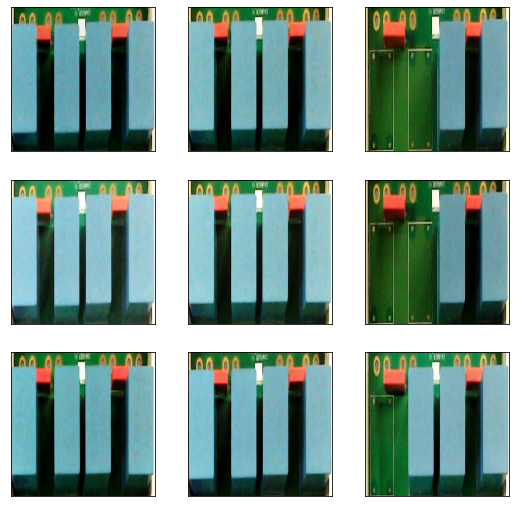

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

# 4. Metryki i analiza

In [ ]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_sample(image):
    return preprocess_image(image)

In [ ]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding = embedding(resnet.preprocess_input(anchor))



In [ ]:
negative_scores = list()
positive_scores = list()


In [ ]:
import timeit


from tqdm import tqdm
negative_images = sorted(
    [str(negative_images_path / f) for f in os.listdir(negative_images_path)]
)

image_count = len(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.map(preprocess_sample)
negative_dataset = negative_dataset.batch(1, drop_remainder=False)
negative_dataset = negative_dataset.prefetch(8)


print("Calculating similarity scores for test data...")
start = timeit.default_timer()
for sample in tqdm(negative_dataset):
  negative_embeding = embedding(resnet.preprocess_input(sample))
  negative_similarity = rmse_similarity(anchor_embedding, negative_embedding)
  negative_scores.append(negative_similarity.numpy())
stop = timeit.default_timer()

print('Czas ', stop - start) 
print('Czas na zdjęcie (pojedyncza inferencja): ', (stop - start)/len(negative_images)) 

Calculating similarity scores for test data...


100%|██████████| 130/130 [00:40<00:00,  3.17it/s]

Czas  40.96473631800001
Czas na zdjęcie (pojedyncza inferencja):  0.31511335629230774


In [ ]:
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(positive_images)

positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
positive_dataset = positive_dataset.map(preprocess_sample)
positive_dataset = positive_dataset.batch(1, drop_remainder=False)
positive_dataset = positive_dataset.prefetch(8)
print(positive_dataset)

print("Calculating similarity scores for test data...")
for sample in tqdm(positive_dataset):
  positive_embeding = embedding(resnet.preprocess_input(sample))
  positive_similarity = rmse_similarity(anchor_embedding, positive_embedding)
  positive_scores.append(positive_similarity.numpy())

130
<PrefetchDataset element_spec=TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None)>
Calculating similarity scores for test data...


100%|██████████| 130/130 [00:24<00:00,  5.41it/s]


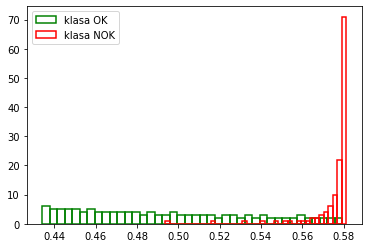

In [ ]:
fig, ax = plt.subplots()
ax.hist(positive_scores, 40, None, ec='green', fc='none', lw=1.5, histtype='barstacked', label='klasa OK')
ax.hist(negative_scores, 40, None, ec='red', fc='none', lw=1.5, histtype='barstacked', label='klasa NOK')
ax.legend(loc='upper left')
plt.show()

4.1. Krzywe 

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,roc_auc_score

precision, recall, thresholds = precision_recall_curve([0]*len(positive_scores)+ [1]*len(negative_scores), positive_scores+negative_scores)

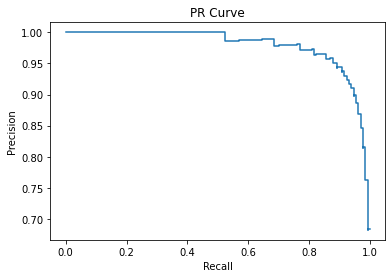

In [ ]:
from sklearn.utils import shuffle
import random
display = PrecisionRecallDisplay(
    recall=recall,
    precision=precision
)

display.plot()
_ = display.ax_.set_title("PR Curve")

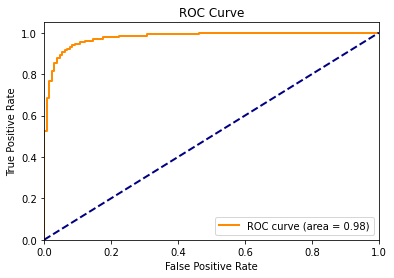

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

n_samples = 1000
pred = np.random.randn(n_samples)
y_test = np.random.randint(2, size=(n_samples,))

max_dist = max(pred)
pred = np.array([1-e/max_dist for e in pred])
fpr, tpr, thresholds = roc_curve([0]*len(positive_scores)+ [1]*len(negative_scores), positive_scores+negative_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

4.2. Wizualizacja głowy sieci

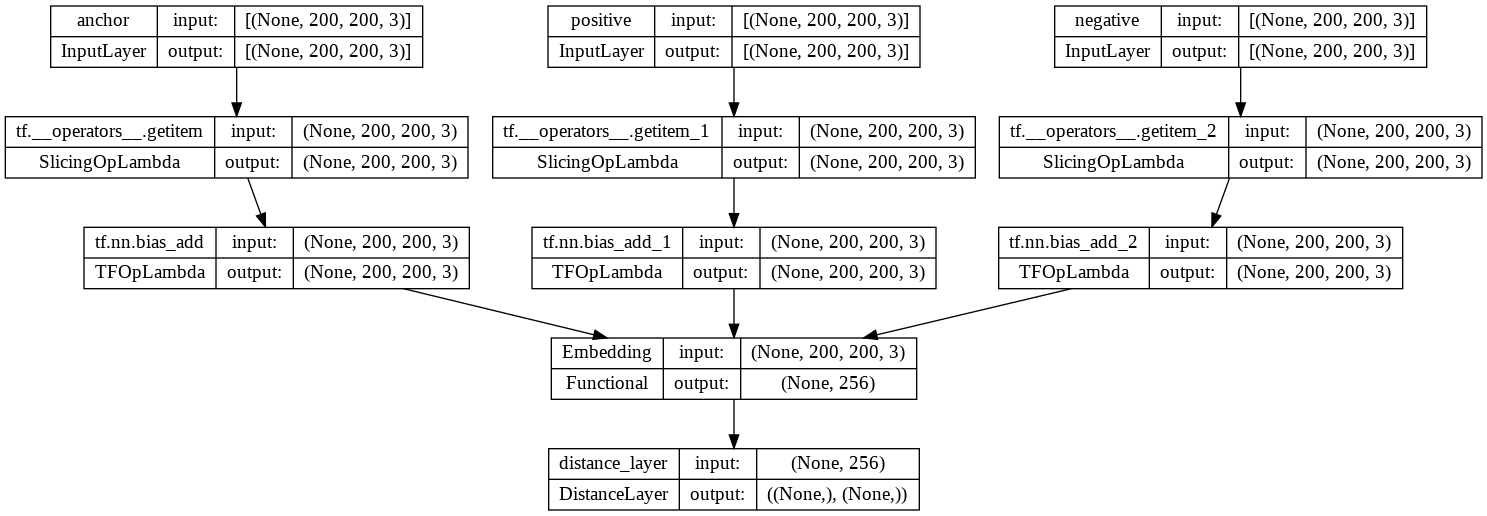

In [ ]:
siamese_model.layers[0].input_shape
siamese_model.build(input_shape=siamese_model.layers[0].input_shape)
tf.keras.utils.plot_model(siamese_model.siamese_network, show_shapes=True)